In [1]:
import re
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
!pip install transformers
import transformers
from transformers import BertTokenizer
from transformers import TFAutoModel

from tensorflow.keras.callbacks import EarlyStopping

print(tf.__version__)
print(transformers.__version__)

2.11.0
4.27.4


# 📋 Loading the Data

In [2]:
import pandas as pd
import numpy as np
import gensim 
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize 
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('/kaggle/input/uk-twitter-covid19-dataset/sample_data.csv')

In [3]:
df.head()

,created_at,user_id,username,tweet,place,near,clean_tweet,tokens,lemma,lemma_sentence,pos_tag,lemma_sentence(with POS),sentiword_analysis,vader_score,textblob_polarity,senti_textblob,senti_wordnet,senti_vader
0,2021-01-06,1063705581133934593,5herii,My kids can never say they don’t wanna do thei...,NaN,London,kids not wana homework sparkles covid sparkles...,"['kids', 'not', 'wana', 'homework', 'sparkles'...","['kid', 'not', 'wana', 'homework', 'sparkle', ...",kid not wana homework sparkle covid sparkle ba...,"[('kids', 'n'), ('not', 'r'), ('wana', 'a'), (...",kid not wana homework sparkle covid sparkle ...,-0.125,0.0634,0.0250,1,-1,1
1,2021-01-06,39230775,djalijournalist,We are not messing about with COVID-19. Wear y...,"{'type': 'Point', 'coordinates': [51.5141, -0....",London,not messing covid wear mask time london united...,"['not', 'messing', 'covid', 'wear', 'mask', 't...","['not', 'messing', 'covid', 'wear', 'mask', 't...",not messing covid wear mask time london united...,"[('not', 'r'), ('messing', 'v'), ('covid', 'n'...",not mess covid wear mask time london united ...,-0.625,0.6007,0.0875,1,-1,1
2,2021-01-06,63469953,aopapilot,@rsmck @underwatergeek @Pilotworldshop @Southe...,NaN,London,problem airfields cost remaining open verses p...,"['problem', 'airfields', 'cost', 'remaining', ...","['problem', 'airfield', 'cost', 'remaining', '...",problem airfield cost remaining open verse pot...,"[('problem', 'n'), ('airfields', 'n'), ('cost'...",problem airfield cost remain open verse pote...,-1.500,0.1779,0.0000,0,-1,1
3,2021-01-06,25303558,gilesyb,"I remain astonished by the stock market, not s...",NaN,London,remain astonished stock market not face riots ...,"['remain', 'astonished', 'stock', 'market', 'n...","['remain', 'astonished', 'stock', 'market', 'n...",remain astonished stock market not face riot i...,"[('remain', 'n'), ('astonished', 'a'), ('stock...",remain astonished stock market not face riot...,-1.125,0.6730,0.2250,1,-1,1
4,2021-01-06,262799412,chutte1,Dear lord Jesus Christ . I thank you for your ...,NaN,London,dear lord jesus christ grace listen prayers la...,"['dear', 'lord', 'jesus', 'christ', 'grace', '...","['dear', 'lord', 'jesus', 'christ', 'grace', '...",dear lord jesus christ grace listen prayer lay...,"[('dear', 'a'), ('lord', 'n'), ('jesus', 'n'),...",dear lord jesus christ grace listen prayer l...,1.000,0.8519,0.0000,0,1,1


In [4]:
df['text'] = df['clean_tweet']
df['target'] = df['senti_textblob']

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[['text','target']], test_size = 0.2, random_state = 42)

In [6]:
train2, test2 = train, test

# 🔨 Preprocessing

In [7]:
#Use regex to clean the data
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text 

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

train['text'] = train['text'].apply(lambda x : remove_url(x))
train['text'] = train['text'].apply(lambda x : remove_punct(x))
train['text'] = train['text'].apply(lambda x : remove_emoji(x))
train['text'] = train['text'].apply(lambda x : decontraction(x))
train['text'] = train['text'].apply(lambda x : seperate_alphanumeric(x))
train['text'] = train['text'].apply(lambda x : unique_char(cont_rep_char,x))

test['text'] = test['text'].apply(lambda x : remove_url(x))
test['text'] = test['text'].apply(lambda x : remove_punct(x))
test['text'] = test['text'].apply(lambda x : remove_emoji(x))
test['text'] = test['text'].apply(lambda x : decontraction(x))
test['text'] = test['text'].apply(lambda x : seperate_alphanumeric(x))
test['text'] = test['text'].apply(lambda x : unique_char(cont_rep_char,x))

# ✂️ Tokenization

In [8]:
seq_len = max([len(text) for text in train['text']]) #256
batch_size = 16
num_samples = len(train)

model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

train_tokens = tokenizer(
    train['text'].tolist(), 
    max_length=seq_len, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True, 
    return_tensors='np'
)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['target'] = le.fit_transform(train['target'])
test['target'] = le.fit_transform(test['target'])

y_train = train['target'].values
labels = np.zeros((num_samples, y_train.max() + 1))
labels[np.arange(num_samples), y_train] = 1

dataset = tf.data.Dataset.from_tensor_slices(
    (
        train_tokens['input_ids'], 
        train_tokens['attention_mask'], 
        labels
    )
)

def map_func(input_ids, masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': masks
    }, labels

dataset = dataset.map(map_func)
dataset = dataset.shuffle(10000).batch(batch_size=batch_size, drop_remainder=True)

split = 0.7
size = int((train_tokens['input_ids'].shape[0] // batch_size) * split)

train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [9]:
size

105

In [10]:
labels.shape

(2400, 3)

# 🤖 Model Building

In [14]:
####### MODEL 3 #########
'''
In this example, a BiLSTM layer is added after the Transformer layer. The number of units in the BiLSTM layer is set to 64, 
but you can modify this value based on your specific use case. The output of the BiLSTM layer is passed through two dense layers, 
each with 512 units and a ReLU activation function, before being fed to the classifier head.
'''

bert_model = TFAutoModel.from_pretrained(model_name)

# Input layers
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# Transformer
embeddings = bert_model(input_ids, attention_mask=mask)[0]
embeddings = tf.keras.layers.GlobalAveragePooling1D()(embeddings)
embeddings = tf.keras.layers.Reshape((1, -1))(embeddings)

# Add a BiLSTM layer
lstm_units = 512 
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True))(embeddings)
attention_layer = tf.keras.layers.Attention()([lstm, lstm])

# Add Dense layers
#x = tf.keras.layers.Dense(512, activation='relu')(lstm)
x = tf.keras.layers.Dense(512, activation='relu')(attention_layer)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

# Flatten the output tensor
x = tf.keras.layers.Flatten()(x)

# Classifier head
outputs = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)

# Create the model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=outputs)

# Compile the model
learning_rate = 4e-5 # 4e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy()
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

'''
In the above example, monitor specifies the metric to be monitored for early stopping, 
patience specifies the number of epochs with no improvement after which training will be stopped, 
mode specifies whether the monitored metric should be minimized or maximized, and 
restore_best_weights specifies whether to restore the weights of the model corresponding to the epoch with the best monitored metric value.

Adagrad
Adadelta
RMSprop

1.2277e-05 (best val loss)


import math
# Define the LearningRateScheduler callback
initial_learning_rate = 1e-3
def lr_exp_decay(epoch):
    k = 0.1
    return initial_learning_rate * math.exp(-k*epoch)

'''

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
#lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_exp_decay)

# Fit the model with early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= 50,
    batch_size=batch_size,
    callbacks=[early_stop]
    #callbacks=[lr_callback] #
)

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50
105/105 [==============================] - 191s 1s/step - loss: 0.9005 - categorical_accuracy: 0.5940 - val_loss: 0.6326 - val_categorical_accuracy: 0.7778
Epoch 2/50
105/105 [==============================] - 146s 1s/step - loss: 0.6709 - categorical_accuracy: 0.7565 - val_loss: 0.4845 - val_categorical_accuracy: 0.8417
Epoch 3/50
105/105 [==============================] - 147s 1s/step - loss: 0.4941 - categorical_accuracy: 0.8268 - val_loss: 0.3830 - val_categorical_accuracy: 0.8500
Epoch 4/50
105/105 [==============================] - 145s 1s/step - loss: 0.4143 - categorical_accuracy: 0.8577 - val_loss: 0.2518 - val_categorical_accuracy: 0.9111
Epoch 5/50
105/105 [==============================] - 146s 1s/step - loss: 0.3163 - categorical_accuracy: 0.8940 - val_loss: 0.1708 - val_categorical_accuracy: 0.9458
Epoch 6/50
105/105 [==============================] - 145s 1s/step - loss: 0.2337 - categorical_accuracy: 0.9256 - val_loss: 0.1233 - val_categorical_accuracy: 0.966

In [22]:


model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
bert_model = TFAutoModel.from_pretrained(model_name)

# Input layers
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# Transformer
embeddings = bert_model(input_ids, attention_mask=mask)[0]
embeddings = tf.keras.layers.GlobalAveragePooling1D()(embeddings)
embeddings = tf.keras.layers.Reshape((1, -1))(embeddings)

# Add BiLSTM layer 1
lstm_units_1 = 512
bilstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=lstm_units_1, return_sequences=True))(embeddings)
bilstm_1 = tf.keras.layers.Dropout(rate=0.2)(bilstm_1)

# Add convolution layers
num_filters = 64
filter_sizes = [5, 5, 3]
conv_activation = 'relu'
dropout_rate = 0.2

conv1 = tf.keras.layers.Conv1D(filters=num_filters, kernel_size=filter_sizes[0], activation=conv_activation, padding='same')(bilstm_1)
conv1 = tf.keras.layers.Dropout(rate=dropout_rate)(conv1)

conv2 = tf.keras.layers.Conv1D(filters=num_filters*2, kernel_size=filter_sizes[1], activation=conv_activation, padding='same')(conv1)
conv2 = tf.keras.layers.Dropout(rate=dropout_rate)(conv2)

conv3 = tf.keras.layers.Conv1D(filters=num_filters*4, kernel_size=filter_sizes[2], activation=conv_activation, padding='same')(conv2)
conv3 = tf.keras.layers.MaxPooling1D(pool_size=3, strides=1, padding='same')(conv3)
conv3 = tf.keras.layers.Dropout(rate=dropout_rate)(conv3)

# Add dense layers
hidden_units = [128, 64]
dense_activation = 'relu'

flatten = tf.keras.layers.Flatten()(conv3)
dense1 = tf.keras.layers.Dense(units=hidden_units[0], activation=dense_activation)(flatten)
dense1 = tf.keras.layers.Dropout(rate=dropout_rate)(dense1)

dense2 = tf.keras.layers.Dense(units=hidden_units[1], activation=dense_activation)(dense1)
dense2 = tf.keras.layers.Dropout(rate=dropout_rate)(dense2)

# Add Output layer
outputs = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(dense2)

# Define model
model = tf.keras.models.Model(inputs=[input_ids, mask], outputs=outputs)

# Compile the model
learning_rate = 4e-5 # 4e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy()
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
#lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_exp_decay)

# Fit the model with early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= 50,
    batch_size=batch_size,
    callbacks=[early_stop]
    #callbacks=[lr_callback] #
)

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50
105/105 [==============================] - 131s 839ms/step - loss: 1.0903 - categorical_accuracy: 0.4393 - val_loss: 1.0526 - val_categorical_accuracy: 0.6083
Epoch 2/50
105/105 [==============================] - 82s 781ms/step - loss: 0.9765 - categorical_accuracy: 0.5970 - val_loss: 0.8922 - val_categorical_accuracy: 0.5986
Epoch 3/50
105/105 [==============================] - 82s 779ms/step - loss: 0.9112 - categorical_accuracy: 0.6012 - val_loss: 0.7619 - val_categorical_accuracy: 0.6667
Epoch 4/50
105/105 [==============================] - 81s 774ms/step - loss: 0.9056 - categorical_accuracy: 0.5714 - val_loss: 0.8061 - val_categorical_accuracy: 0.6139
Epoch 5/50
105/105 [==============================] - 81s 773ms/step - loss: 0.8372 - categorical_accuracy: 0.6149 - val_loss: 0.8238 - val_categorical_accuracy: 0.6403
Epoch 6/50
105/105 [==============================] - 82s 778ms/step - loss: 0.8229 - categorical_accuracy: 0.6482 - val_loss: 0.6659 - val_categorical_ac

# Model Architecture

In [23]:
bert_model = model

In [24]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 339)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 339)]        0           []                               
                                                                                                  
 tf_roberta_model_10 (TFRoberta  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 Model)                         thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 339,                                           

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


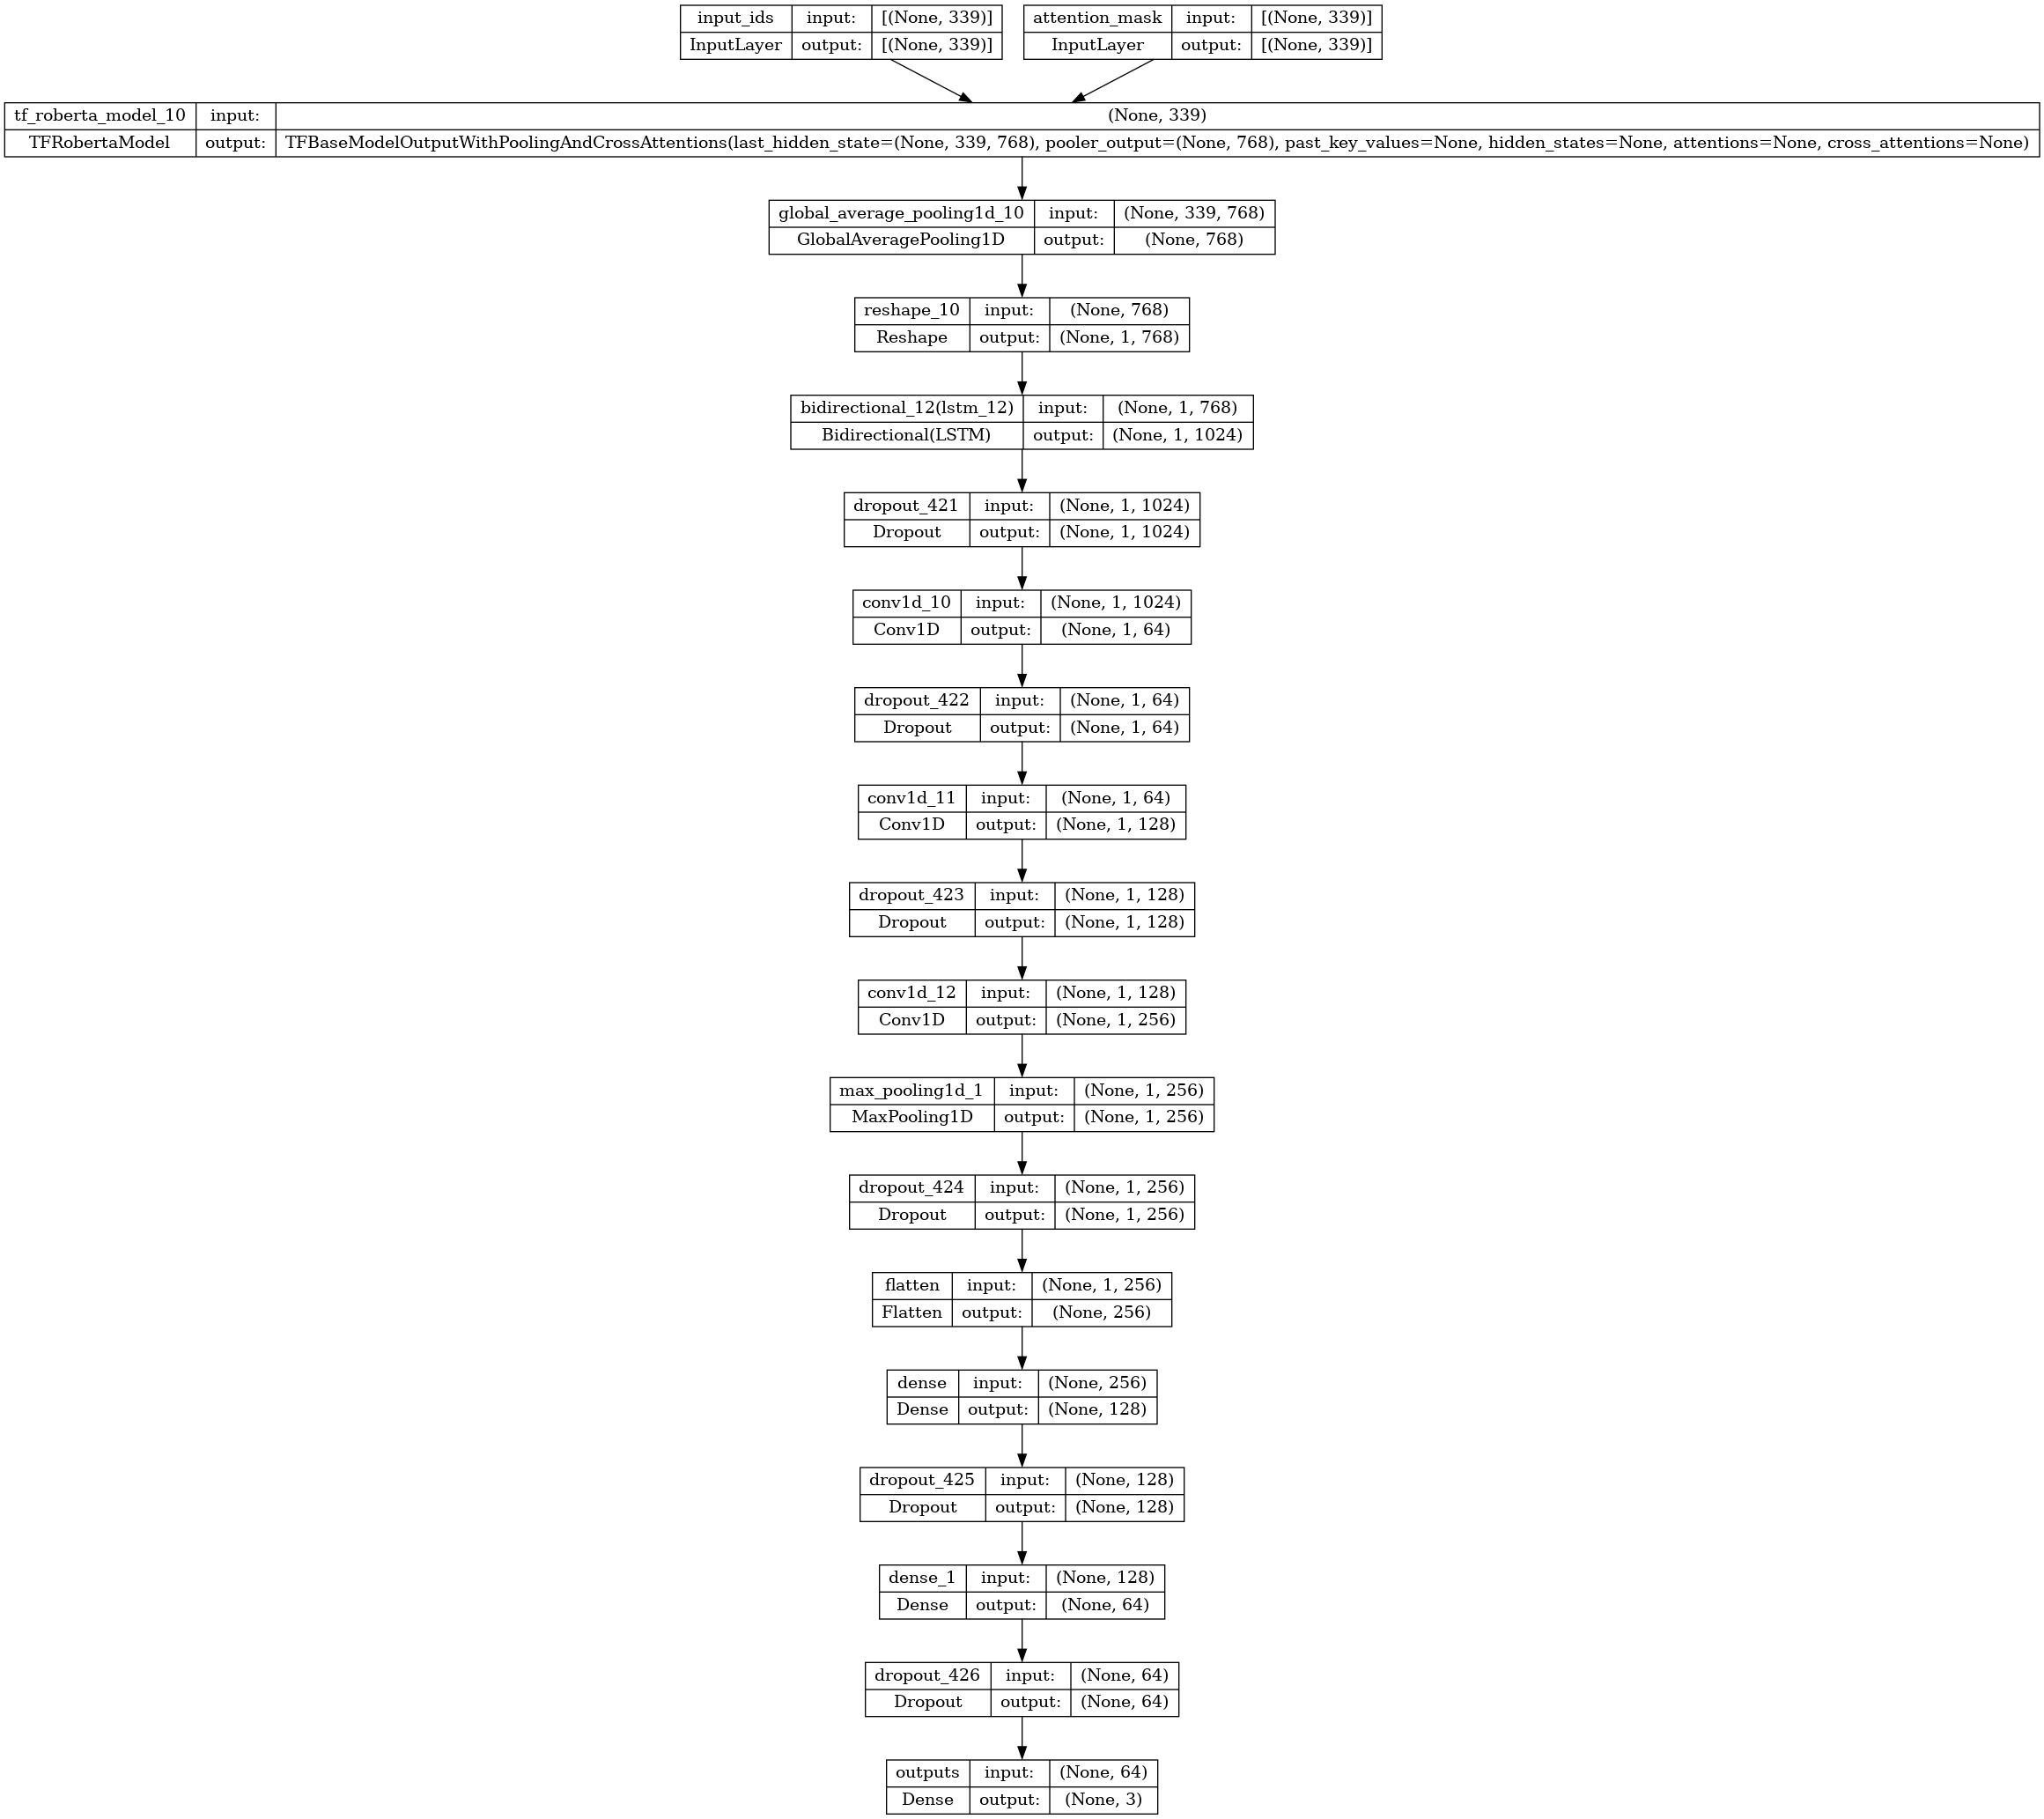

In [25]:
tf.keras.utils.plot_model(bert_model, to_file = 'bert_model1.png', show_shapes=True, show_layer_names = True)

# 📊 Model Evaluation

In [26]:
# For Data Visualization
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import wordcloud

# Miscellaneous
from tqdm import tqdm
import os
import random
from IPython import display

In [27]:
def plot_learning_evolution(r):
    plt.figure(figsize=(8, 6))
    
    #plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during training')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('loss1.png')
    
    plt.figure(figsize=(8, 6))
    #plt.subplot(2, 2, 2)
    plt.plot(r.history['categorical_accuracy'], label='categorical_accuracy')
    plt.plot(r.history['val_categorical_accuracy'], label='val_categorical_accuracy')
    plt.title('Accuracy score evolution during training')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.savefig('accuracy1.png')

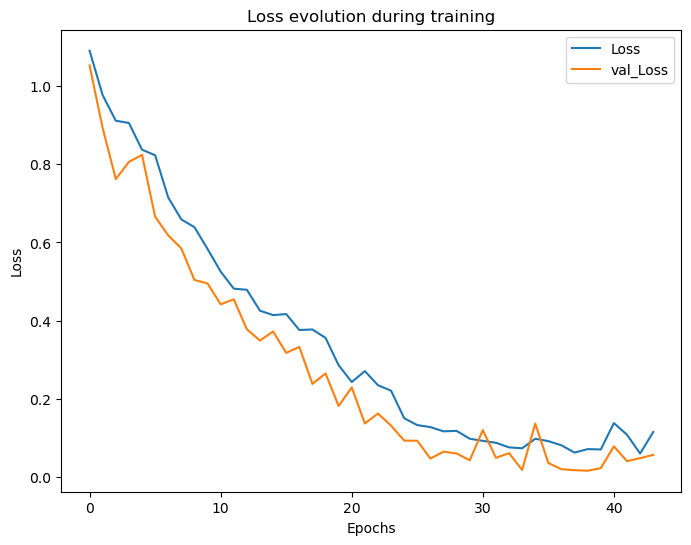

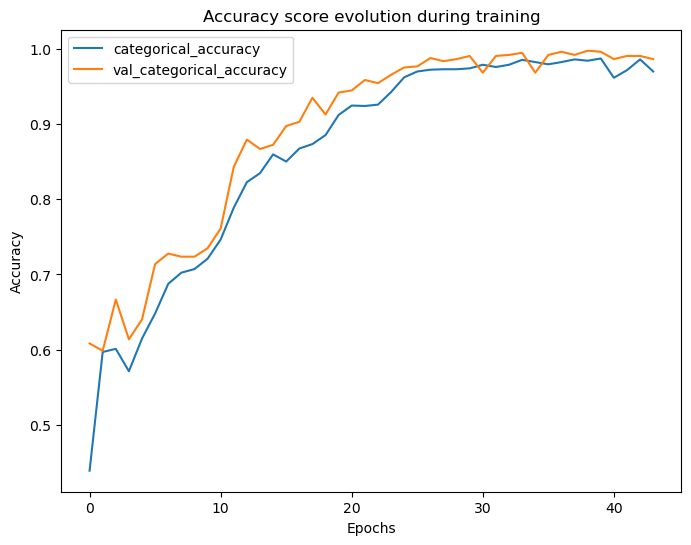

In [28]:
plot_learning_evolution(history)

In [29]:
bert_model.evaluate(val_ds)

45/45 [==============================] - 10s 229ms/step - loss: 0.0157 - categorical_accuracy: 0.9972


[0.0157355647534132, 0.9972222447395325]

In [30]:
bert_model.evaluate(train_ds)

105/105 [==============================] - 24s 227ms/step - loss: 0.0510 - categorical_accuracy: 0.9917


[0.051037732511758804, 0.9916666746139526]

In [31]:
def prep_data(text):
    tokens = tokenizer(
        text, max_length=seq_len, truncation=True, 
        padding='max_length', 
        add_special_tokens=True, 
        return_tensors='tf'
    )
    return {
        'input_ids': tokens['input_ids'], 
        'attention_mask': tokens['attention_mask']
    }

test['prediction'] = None

for i, row in test.iterrows():
    tokens = prep_data(row['text'])
    #probs = bert_model.predict(tokens)
    probs = bert_model.predict_on_batch(tokens)
    pred = np.argmax(probs)
    test.at[i, 'prediction'] = pred
    
test['prediction'] = test['prediction'].astype(int)
test

,text,target,prediction
1801,not job hope sadly needed current situation co...,0,1
1190,black jesus cure covid,0,0
1817,wedding honeymoon add rearranged times due tho...,0,0
251,update dad hospital care monitored closely slo...,0,2
2505,signed petition demanding government houses ro...,0,0
...,...,...,...
104,icu nurse friend beds people hospital covid sy...,1,1
2087,gov trading country scientists blocked entry t...,1,2
599,totally agree covid bridge communicate public ...,2,2
1756,covid not causing issues pre january,1,1


In [32]:
labels = ['Negative','Neutral','Positive']
from sklearn.metrics import classification_report
print(classification_report(test['target'], test['prediction'], target_names=labels))

              precision    recall  f1-score   support

    Negative       0.80      0.67      0.73       135
     Neutral       0.87      0.89      0.88       238
    Positive       0.80      0.87      0.84       227

    accuracy                           0.83       600
   macro avg       0.83      0.81      0.82       600
weighted avg       0.83      0.83      0.83       600



In [33]:
test.head()

,text,target,prediction
1801,not job hope sadly needed current situation co...,0,1
1190,black jesus cure covid,0,0
1817,wedding honeymoon add rearranged times due tho...,0,0
251,update dad hospital care monitored closely slo...,0,2
2505,signed petition demanding government houses ro...,0,0


In [34]:
test.target.value_counts()

1    238
2    227
0    135
Name: target, dtype: int64

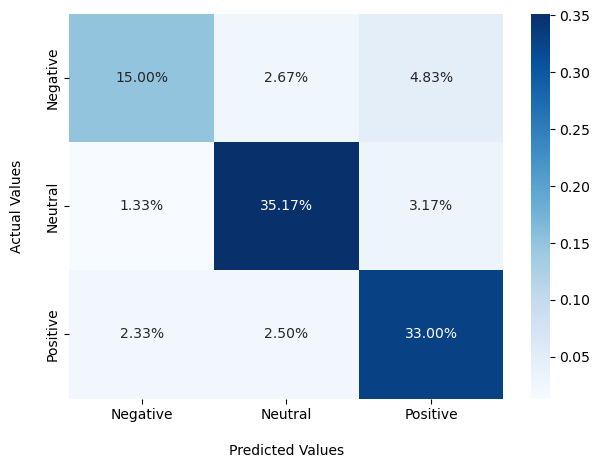

In [35]:
from sklearn.metrics import *
cm = confusion_matrix(test['target'], test['prediction'])

plt.figure(figsize=(7,5))

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.savefig('cm.png')
plt.show()

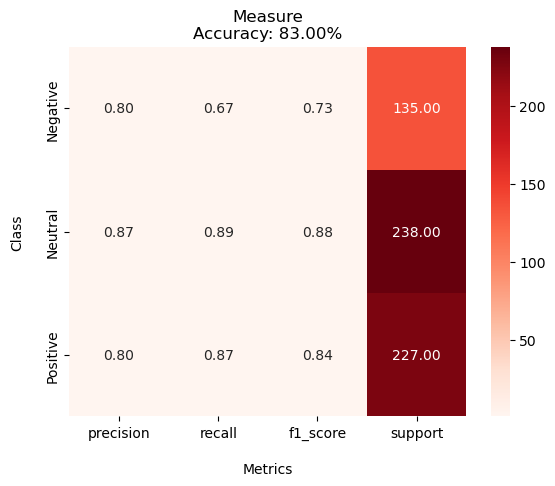

In [36]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


def plot_classification_report(report):
    report_data = []
    lines = report.split('\n')
    lines = list(filter(None, lines))
    for line in lines[1:-3]:
        row = {}
        row_data = line.split()
        row_data = list(filter(None, row_data))
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    df = pd.DataFrame.from_dict(report_data)
    df.set_index('class', inplace=True)
    heatmap = sns.heatmap(df, annot=True, cmap='Reds', fmt='.2f')
    heatmap.set_xlabel('\nMetrics')
    heatmap.set_ylabel('Class\n')
    heatmap.set_title('Classification Report')


def accuracy_score(report):
    report_data = []
    lines = report.split('\n')
    lines = list(filter(None, lines))
    for line in lines[4:-2]:
        row_data = line.split()
        row_data = list(filter(None, row_data))
        return float(row_data[1])


labels = ['Negative','Neutral','Positive']

report = classification_report(test['target'], test['prediction'], target_names=labels)
plot_classification_report(report)
accuracy = accuracy_score(report)

plt.title('Measure\nAccuracy: {:.2f}%'.format(accuracy*100))
plt.savefig('classification_reports.png')
plt.show()
